In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import yfinance as yf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pytz

In [2]:
xmr = yf.Ticker("XMR-USD XMR-BTC XMR-EUR XMR-CNY")
df = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df['Date'].min().date()

datetime.date(2017, 11, 9)

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
...,...,...,...,...,...,...,...
2162,2023-10-11,152.220093,153.929443,150.970428,153.842102,153.842102,61162383
2163,2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853
2164,2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283
2165,2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438


In [5]:
### Get Gold, Silver and Copper closing prices in our dataframe's date range.

### Define date range
start_Date = df['Date'].min().date()
end_Date = df['Date'].max().date()

gold = yf.Ticker("GC=F")
gold_hist = gold.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
gold_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
gold_hist.reset_index(inplace=True)
gold_hist['Date'] = gold_hist['Date'].dt.tz_convert(pytz.UTC)
gold_close=gold_hist[['Close']]

silver = yf.Ticker("SI=F")
silver_hist = silver.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
silver_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
silver_hist.reset_index(inplace=True)
silver_hist['Date'] = silver_hist['Date'].dt.tz_convert(pytz.UTC)
silver_close=silver_hist[['Close']]

copper = yf.Ticker("HG=F")
copper_hist = copper.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
copper_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
copper_hist.reset_index(inplace=True)
copper_hist['Date'] = copper_hist['Date'].dt.tz_convert(pytz.UTC)
copper_close=copper_hist[['Close']]

In [6]:
metal_df  = pd.concat([gold_close, silver_close,copper_close], axis=1)

metal_df .columns = ['gold_close', 'silver_close', 'copper_close']
metal_df 


,gold_close,silver_close,copper_close
0,1285.599976,16.943001,3.0800
1,1272.400024,16.844000,3.0695
2,1277.300049,17.023001,3.1115
3,1281.500000,17.052000,3.0600
4,1276.500000,16.950001,3.0490
...,...,...,...
1485,1849.500000,21.740999,3.6425
1486,1861.000000,21.775999,3.6320
1487,1872.800049,21.957001,3.6140
1488,1869.300049,21.792000,3.5940


In [7]:
bitcoin = yf.Ticker("BTC-USD")
bitcoin_hist = bitcoin.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bitcoin_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bitcoin_hist.reset_index(inplace=True)
bitcoin_hist['Date'] = bitcoin_hist['Date'].dt.tz_convert(pytz.UTC)
bitcoin_close=bitcoin_hist[['Close']]

ethereum = yf.Ticker("ETH-USD")
ethereum_hist = ethereum.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
ethereum_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
ethereum_hist.reset_index(inplace=True)
ethereum_hist['Date'] = ethereum_hist['Date'].dt.tz_convert(pytz.UTC)
ethereum_close=ethereum_hist[['Close']]

tether = yf.Ticker("USDT-USD")
tether_hist = tether.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
tether_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
tether_hist.reset_index(inplace=True)
tether_hist['Date'] = tether_hist['Date'].dt.tz_convert(pytz.UTC)
tether_close=tether_hist[['Close']]

bnb = yf.Ticker("BNB-USD")
bnb_hist = bnb.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bnb_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bnb_hist.reset_index(inplace=True)
bnb_hist['Date'] = bnb_hist['Date'].dt.tz_convert(pytz.UTC)
bnb_close=bnb_hist[['Close']]

xrp = yf.Ticker("XRP-USD")
xrp_hist = xrp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
xrp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
xrp_hist.reset_index(inplace=True)
xrp_hist['Date'] = xrp_hist['Date'].dt.tz_convert(pytz.UTC)
xrp_close=xrp_hist[['Close']]


In [8]:
import pandas as pd
crypto_df  = pd.concat([bitcoin_close, ethereum_close,tether_close,bnb_close, xrp_close], axis=1)
crypto_df .columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close']
crypto_df 

,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close
0,7143.580078,320.884003,1.008180,1.990770,0.217488
1,6618.140137,299.252991,1.006010,1.796840,0.206483
2,6357.600098,314.681000,1.008990,1.670470,0.210430
3,5950.069824,307.907990,1.012470,1.519690,0.197339
4,6559.490234,316.716003,1.009350,1.686620,0.203442
...,...,...,...,...,...
2161,27391.019531,1567.713013,1.000088,208.576874,0.497436
2162,26873.320312,1566.254761,0.999752,206.533417,0.488838
2163,26756.798828,1539.612427,0.999708,205.229416,0.483050
2164,26862.375000,1552.089478,0.999960,206.036118,0.485699


In [9]:
import pandas as pd

average_value = metal_df .mean()
merged_df = pd.concat([crypto_df , metal_df ], axis=1)
merged_df.fillna(average_value, inplace=True)
merged_df.columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close',
                     'gold_close', 'silver_close', 'copper_close']

merged_df

,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close,gold_close,silver_close,copper_close
0,7143.580078,320.884003,1.008180,1.990770,0.217488,1285.599976,16.943001,3.080000
1,6618.140137,299.252991,1.006010,1.796840,0.206483,1272.400024,16.844000,3.069500
2,6357.600098,314.681000,1.008990,1.670470,0.210430,1277.300049,17.023001,3.111500
3,5950.069824,307.907990,1.012470,1.519690,0.197339,1281.500000,17.052000,3.060000
4,6559.490234,316.716003,1.009350,1.686620,0.203442,1276.500000,16.950001,3.049000
...,...,...,...,...,...,...,...,...
2161,27391.019531,1567.713013,1.000088,208.576874,0.497436,1641.344764,20.256493,3.405891
2162,26873.320312,1566.254761,0.999752,206.533417,0.488838,1641.344764,20.256493,3.405891
2163,26756.798828,1539.612427,0.999708,205.229416,0.483050,1641.344764,20.256493,3.405891
2164,26862.375000,1552.089478,0.999960,206.036118,0.485699,1641.344764,20.256493,3.405891


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2167 non-null   datetime64[ns]
 1   Open       2167 non-null   float64       
 2   High       2167 non-null   float64       
 3   Low        2167 non-null   float64       
 4   Close      2167 non-null   float64       
 5   Adj Close  2167 non-null   float64       
 6   Volume     2167 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 118.6 KB


In [15]:
def clean_hash_difficulty_files(files: list):
    final_files = []
    for file in files:
        ### Read xmr_difficulty file and make necessary changes
        # file = pd.read_csv(f'./data_phase2/{file}', index_col=None)
        # D:\quera\tamrin\faz2\XMR_difficulty.csv
        file = pd.read_csv(f'{file}', index_col=None)
        file.drop(columns=['Unnamed: 0'], inplace=True)

        ### Convert hourly difficulty rates to daily
        # First, ensure that the 'time' column is of datetime type
        file['time'] = pd.to_datetime(file['time'])

        # Set 'time' as the index for the DataFrame
        file.set_index('time', inplace=True)

        # Use the resample method to aggregate hourly data to daily data
        rate = ''
        if 'difficulty' in file.columns:
            rate_col = 'difficulty'
        elif 'hash' in file.columns:
            rate_col = 'hash'
        converted_rate = file[rate_col].resample('D').mean()
        converted_rate = pd.DataFrame(converted_rate)
        converted_rate.reset_index(inplace=True)
        
        ### Remove UTC time format from its time column
        converted_rate['time'] = converted_rate['time'].dt.tz_localize(None)

        ### Filter converted_rate date range to correspond to date range in df( aka XMR-Monero)
        start_date = df['Date'].min()
        ### converted_rate ends in 2023-10-08 so forcibly we have to cut df short to 2023-10-08 
        end_date = df['Date'].max()

        ### Final file named With daily rates instead of hourly 
        ### And Correct date range
        ### Note : There are still 6 rows missing in converted_rate_with_range which has to be dropped from df  
        converted_rate_with_range = converted_rate[
            (converted_rate['time'] >= start_date) & (converted_rate['time'] <= end_date)
        ]
        converted_rate_with_range.reset_index(drop=True, inplace=True)
        converted_rate_with_range = converted_rate_with_range.rename(columns={'time': 'Date'})
        final_files.append(converted_rate_with_range)
    return final_files

In [16]:
### difficulty_hash_final_files contains a list with 2 elements 
### At index 0 it has final xmr_difficulty file
### At index 1 it has final xmr_hash file 
difficulty_hash_final_files = clean_hash_difficulty_files(files=['XMR_difficulty.csv', 'XMR_hash.csv'])

In [17]:
### Merge difficulty and hash into XMR-Monro (our main df)
for file in difficulty_hash_final_files:
    df = pd.merge(df, file, on='Date')
df

,Date,Open,High,Low,Close,Adj Close,Volume,difficulty,hash
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,2.806786e+10,2.338989e+08
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,2.805339e+10,2.337782e+08
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,2.805339e+10,2.337782e+08
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,2.805339e+10,2.337782e+08
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,2.805339e+10,2.337782e+08
...,...,...,...,...,...,...,...,...,...
2155,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,3.423015e+11,2.852512e+09
2156,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,3.338542e+11,2.782118e+09
2157,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,3.580862e+11,2.984052e+09
2158,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,3.445453e+11,2.871211e+09


In [30]:
### Add Target vector as a separate column to dataframe for later reference
### This is Target Vector
df['Price_Direction'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [31]:
df['HighLow'] = df['High'] - df['Low']
df['OpenClose'] = df['Open'] - df['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume,difficulty,hash,Price_Direction,HighLow,OpenClose,RSI,EMA,SMA,macd,macd_s
0,2017-12-12,281.490997,319.897003,281.187988,308.066986,308.066986,271785984,4.530650e+10,3.775541e+08,0,38.709015,-26.575989,70.806026,295.598508,239.565927,37.679664,32.291742
1,2017-12-13,307.431000,330.346008,284.743988,305.744995,305.744995,248583008,4.513219e+10,3.761016e+08,1,45.602020,1.686005,81.378703,302.362833,249.394141,39.138027,33.660999
2,2017-12-14,303.264008,335.527008,301.395996,325.205994,325.205994,261052992,4.355363e+10,3.629469e+08,0,34.131012,-21.941986,81.992481,317.591607,259.756141,41.387047,35.206209
3,2017-12-15,325.605988,326.075989,296.078003,312.321991,312.321991,163054000,5.051779e+10,4.209816e+08,1,29.997986,13.283997,76.525524,314.078530,268.426425,41.649669,36.494901
4,2017-12-16,312.609985,331.542999,311.710999,327.321014,327.321014,164860992,5.387147e+10,4.489289e+08,1,19.832001,-14.711029,76.819630,322.906853,277.304070,42.577289,37.711379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,3.423015e+11,2.852512e+09,0,4.761566,-3.300613,55.293492,149.335187,145.995108,0.834988,0.334071
2114,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,3.338542e+11,2.782118e+09,1,2.762878,0.850479,60.981030,149.527541,146.311152,0.989592,0.465175
2115,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,3.580862e+11,2.984052e+09,1,4.027649,-2.368927,65.502272,151.170690,146.806604,1.288387,0.629817
2116,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,3.445453e+11,2.871211e+09,1,4.146545,-3.223907,80.032795,153.864992,147.764794,1.764659,0.856786


In [42]:
### Calculate RSI Indicator

### First Calculate the difference of each day's price with prior day
change = df["Close"].diff()
change = change.dropna()

### Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

### Verify no mistakes were made
change.equals(change_up+change_down)

### Calculate the rolling average of average up and average down
window_size = 14
avg_up = change_up.rolling(window_size).mean()
avg_down = change_down.rolling(window_size).mean().abs()

### Calculate RSI using its formula
rsi = 100 * avg_up / (avg_up + avg_down)

### Add RSI index to dataframe
df['RSI'] = rsi
rsi.isna().value_counts()

Close
False    2071
True       13
Name: count, dtype: int64

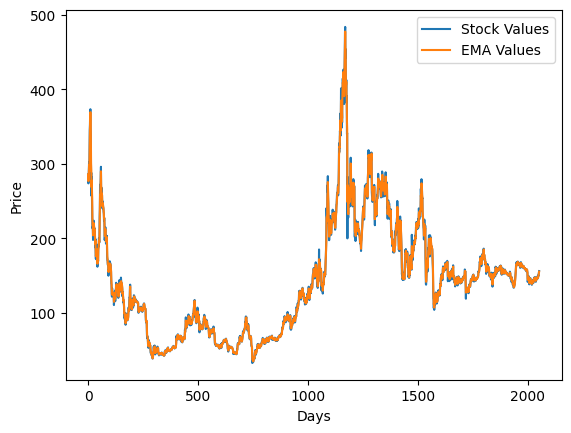

In [52]:
### Calculate EMA Indicator

ema = df['Close'].ewm(com=0.5).mean()
### Add EMA index to dataframe
df['EMA'] = ema

### Comparison plot b/w stock values & EMA
plt.plot(df['Close'], label="Stock Values")
plt.plot(ema, label="EMA Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show() 
### We can see that EMA index predicts out stock value (closing price) pretty good.

In [53]:
### Calculate SMA Indicator

### Get the window of series of observations of specified window size 
window_size = 14
windows = df['Close'].rolling(window_size) 
  
### Create a series of simple moving averages of each window 
sma = windows.mean() 

### Add SMA index to dataframe
df['SMA'] = sma

In [54]:
### Calculate MACD Indicator

### Get the 26-day EMA of the closing price
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
### Get the 12-day EMA of the closing price
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()

### Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

### Get the 9-Day EMA of the MACD for the Trigger line
### Slow MACD
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

### Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

### Add MACD new values to the dataframe
df['macd'] = macd
# df_xmr_usd['macd_h'] = macd_h
df['macd_s'] = macd_s

In [55]:
### Calculate Bollinger Band Indicator

# df = df_xmr_usd[['Close']]

# sma = df.rolling(window=20).mean().dropna()
# rstd = df.rolling(window=20).std().dropna()

# upper_band = sma + 2 * rstd
# lower_band = sma - 2 * rstd

# upper_band = upper_band.rename(columns={'Close': 'upper_band'})
# lower_band = lower_band.rename(columns={'Close': 'lower_band'})
# df_xmr_usd = df_xmr_usd.join(upper_band).join(lower_band)
# df_xmr_usd.head(50)

In [56]:
### Drop NaN values because of the nature of RSI, EMA, SMA and MACD calculations >>> This is normal.
df.dropna(inplace=True)
### Reset Index
df.reset_index(drop=True, inplace=True)

### Assign features and target 
y = df['Price_Direction']
X = df.drop(columns=['Price_Direction', 'Date'])

In [57]:
### Use Grid Search for optimal K

### Feature scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

### Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neighbors': range(1, 21)  
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, scoring='f1')

In [58]:
### Create and Train KNeighborsClassifier model 
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors(or k) by grid search is : {best_n_neighbors}\n")
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best n_neighbors(or k) by grid search is : 13



KNeighborsClassifier(n_neighbors=13)

In [59]:
y_predict = knn.predict(X_test)

In [60]:
f1 = f1_score(y_test, y_predict)
print(f"F1 score : {f1 * 100}")

F1 score : 55.605381165919276
